In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load MNIST dataset

transform = transforms.Compose([
    #torchvision.transforms.Resize(14),      # Resize the image
    transforms.ToTensor(),                  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [3]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

img_res = images.shape[3]

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


In [4]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        self.layers = layers
        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.build_layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.build_layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.layers = layers
        self.num_parameters = self.count_params(layers, grid_size)
        self.build_layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.build_layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [5]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, img_res*img_res).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, img_res*img_res).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t     Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [6]:
def build_data_frame(model, num_epochs, train_losses, train_accs, val_losses, val_accs, time, separator):

    df = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        })
    
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Mean', 'Time': df['Time'].mean()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df = pd.concat([df, separator], ignore_index=True)

    return df

In [7]:
# Define models and parameters

model_list_mlp = [
    MyMLP([img_res*img_res, 128, 10]),
    MyMLP([img_res*img_res, 64, 10]),
    MyMLP([img_res*img_res, 15, 10]),
    MyMLP([img_res*img_res, 5, 10]),
    MyMLP([img_res*img_res, 10, 10, 10]),
    MyMLP([img_res*img_res, 5, 5, 10]),
    ]
model_list_kan = [
    MyKAN([img_res*img_res, 128, 10], grid_size=5),
    MyKAN([img_res*img_res, 64, 10], grid_size=5),
    MyKAN([img_res*img_res, 10, 10], grid_size=5),
    MyKAN([img_res*img_res, 5, 10], grid_size=5),
    MyKAN([img_res*img_res, 10, 10, 10], grid_size=5),
    MyKAN([img_res*img_res, 5, 5, 10], grid_size=5)
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
df_kan = pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time'])
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)

    single_df_mlp = build_data_frame(model_mlp, num_epochs, train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp, separator)
    single_df_kan = build_data_frame(model_kan, num_epochs, train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan, separator)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" ([784, 128, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 101770



100%|██████████| 938/938 [00:06<00:00, 137.09it/s]


Epoch [1/10], Train Loss: 0.3927, Train Accuracy: 0.8869, Time: 6.84s
	     Valid Loss: 0.2509, Valid Accuracy: 0.9358



100%|██████████| 938/938 [00:06<00:00, 148.65it/s]


Epoch [2/10], Train Loss: 0.2067, Train Accuracy: 0.9413, Time: 6.31s
	     Valid Loss: 0.1870, Valid Accuracy: 0.9475



100%|██████████| 938/938 [00:06<00:00, 144.56it/s]


Epoch [3/10], Train Loss: 0.1462, Train Accuracy: 0.9582, Time: 6.49s
	     Valid Loss: 0.1363, Valid Accuracy: 0.9639



100%|██████████| 938/938 [00:06<00:00, 146.92it/s]


Epoch [4/10], Train Loss: 0.1179, Train Accuracy: 0.9659, Time: 6.39s
	     Valid Loss: 0.1195, Valid Accuracy: 0.9707



100%|██████████| 938/938 [00:06<00:00, 150.61it/s]


Epoch [5/10], Train Loss: 0.0983, Train Accuracy: 0.9707, Time: 6.23s
	     Valid Loss: 0.1163, Valid Accuracy: 0.9726



100%|██████████| 938/938 [00:06<00:00, 147.50it/s]


Epoch [6/10], Train Loss: 0.0868, Train Accuracy: 0.9749, Time: 6.36s
	     Valid Loss: 0.0983, Valid Accuracy: 0.9771



100%|██████████| 938/938 [00:06<00:00, 141.96it/s]


Epoch [7/10], Train Loss: 0.0773, Train Accuracy: 0.9773, Time: 6.61s
	     Valid Loss: 0.1108, Valid Accuracy: 0.9728



100%|██████████| 938/938 [00:06<00:00, 149.99it/s]


Epoch [8/10], Train Loss: 0.0706, Train Accuracy: 0.9790, Time: 6.25s
	     Valid Loss: 0.1080, Valid Accuracy: 0.9745



100%|██████████| 938/938 [00:06<00:00, 146.75it/s]


Epoch [9/10], Train Loss: 0.0634, Train Accuracy: 0.9810, Time: 6.39s
	     Valid Loss: 0.1001, Valid Accuracy: 0.9770



100%|██████████| 938/938 [00:06<00:00, 150.04it/s]


Epoch [10/10], Train Loss: 0.0592, Train Accuracy: 0.9819, Time: 6.25s
	     Valid Loss: 0.1058, Valid Accuracy: 0.9770

Training model "MyKAN" ([784, 128, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 508160



100%|██████████| 938/938 [00:07<00:00, 126.06it/s]


Epoch [1/10], Train Loss: 0.3606, Train Accuracy: 0.8959, Time: 7.44s
	     Valid Loss: 0.2098, Valid Accuracy: 0.9445



100%|██████████| 938/938 [00:07<00:00, 125.65it/s]


Epoch [2/10], Train Loss: 0.1578, Train Accuracy: 0.9551, Time: 7.47s
	     Valid Loss: 0.1310, Valid Accuracy: 0.9685



100%|██████████| 938/938 [00:07<00:00, 126.51it/s]


Epoch [3/10], Train Loss: 0.1002, Train Accuracy: 0.9715, Time: 7.42s
	     Valid Loss: 0.1053, Valid Accuracy: 0.9735



100%|██████████| 938/938 [00:07<00:00, 126.71it/s]


Epoch [4/10], Train Loss: 0.0709, Train Accuracy: 0.9798, Time: 7.40s
	     Valid Loss: 0.0935, Valid Accuracy: 0.9771



100%|██████████| 938/938 [00:07<00:00, 126.52it/s]


Epoch [5/10], Train Loss: 0.0506, Train Accuracy: 0.9863, Time: 7.41s
	     Valid Loss: 0.0959, Valid Accuracy: 0.9771



100%|██████████| 938/938 [00:07<00:00, 121.75it/s]


Epoch [6/10], Train Loss: 0.0383, Train Accuracy: 0.9899, Time: 7.71s
	     Valid Loss: 0.0790, Valid Accuracy: 0.9823



100%|██████████| 938/938 [00:07<00:00, 125.99it/s]


Epoch [7/10], Train Loss: 0.0286, Train Accuracy: 0.9924, Time: 7.45s
	     Valid Loss: 0.0887, Valid Accuracy: 0.9798



100%|██████████| 938/938 [00:07<00:00, 125.78it/s]


Epoch [8/10], Train Loss: 0.0211, Train Accuracy: 0.9947, Time: 7.46s
	     Valid Loss: 0.0844, Valid Accuracy: 0.9816



100%|██████████| 938/938 [00:07<00:00, 126.57it/s]


Epoch [9/10], Train Loss: 0.0160, Train Accuracy: 0.9964, Time: 7.41s
	     Valid Loss: 0.0876, Valid Accuracy: 0.9824



100%|██████████| 938/938 [00:07<00:00, 126.64it/s]


Epoch [10/10], Train Loss: 0.0127, Train Accuracy: 0.9973, Time: 7.41s
	     Valid Loss: 0.1146, Valid Accuracy: 0.9767

Training model "MyMLP" ([784, 64, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 50890



100%|██████████| 938/938 [00:06<00:00, 151.11it/s]


Epoch [1/10], Train Loss: 0.4252, Train Accuracy: 0.8801, Time: 6.21s
	     Valid Loss: 0.2762, Valid Accuracy: 0.9236



100%|██████████| 938/938 [00:06<00:00, 150.44it/s]


Epoch [2/10], Train Loss: 0.2458, Train Accuracy: 0.9294, Time: 6.24s
	     Valid Loss: 0.1963, Valid Accuracy: 0.9464



100%|██████████| 938/938 [00:06<00:00, 150.20it/s]


Epoch [3/10], Train Loss: 0.1852, Train Accuracy: 0.9469, Time: 6.25s
	     Valid Loss: 0.1787, Valid Accuracy: 0.9475



100%|██████████| 938/938 [00:06<00:00, 145.17it/s]


Epoch [4/10], Train Loss: 0.1527, Train Accuracy: 0.9555, Time: 6.46s
	     Valid Loss: 0.1661, Valid Accuracy: 0.9565



100%|██████████| 938/938 [00:06<00:00, 149.16it/s]


Epoch [5/10], Train Loss: 0.1300, Train Accuracy: 0.9619, Time: 6.29s
	     Valid Loss: 0.1323, Valid Accuracy: 0.9660



100%|██████████| 938/938 [00:06<00:00, 150.55it/s]


Epoch [6/10], Train Loss: 0.1175, Train Accuracy: 0.9659, Time: 6.23s
	     Valid Loss: 0.1376, Valid Accuracy: 0.9654



100%|██████████| 938/938 [00:06<00:00, 146.90it/s]


Epoch [7/10], Train Loss: 0.1061, Train Accuracy: 0.9685, Time: 6.39s
	     Valid Loss: 0.1227, Valid Accuracy: 0.9699



100%|██████████| 938/938 [00:06<00:00, 150.82it/s]


Epoch [8/10], Train Loss: 0.0985, Train Accuracy: 0.9705, Time: 6.22s
	     Valid Loss: 0.1240, Valid Accuracy: 0.9676



100%|██████████| 938/938 [00:06<00:00, 149.11it/s]


Epoch [9/10], Train Loss: 0.0920, Train Accuracy: 0.9733, Time: 6.29s
	     Valid Loss: 0.1145, Valid Accuracy: 0.9728



100%|██████████| 938/938 [00:06<00:00, 151.25it/s]


Epoch [10/10], Train Loss: 0.0862, Train Accuracy: 0.9749, Time: 6.20s
	     Valid Loss: 0.1169, Valid Accuracy: 0.9734

Training model "MyKAN" ([784, 64, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 254080



100%|██████████| 938/938 [00:07<00:00, 126.02it/s]


Epoch [1/10], Train Loss: 0.3937, Train Accuracy: 0.8880, Time: 7.44s
	     Valid Loss: 0.2165, Valid Accuracy: 0.9438



100%|██████████| 938/938 [00:07<00:00, 124.56it/s]


Epoch [2/10], Train Loss: 0.1799, Train Accuracy: 0.9491, Time: 7.53s
	     Valid Loss: 0.1412, Valid Accuracy: 0.9651



100%|██████████| 938/938 [00:07<00:00, 125.80it/s]


Epoch [3/10], Train Loss: 0.1191, Train Accuracy: 0.9664, Time: 7.46s
	     Valid Loss: 0.1295, Valid Accuracy: 0.9693



100%|██████████| 938/938 [00:07<00:00, 125.44it/s]


Epoch [4/10], Train Loss: 0.0876, Train Accuracy: 0.9750, Time: 7.48s
	     Valid Loss: 0.1013, Valid Accuracy: 0.9756



100%|██████████| 938/938 [00:07<00:00, 126.13it/s]


Epoch [5/10], Train Loss: 0.0655, Train Accuracy: 0.9821, Time: 7.44s
	     Valid Loss: 0.1024, Valid Accuracy: 0.9752



100%|██████████| 938/938 [00:07<00:00, 123.74it/s]


Epoch [6/10], Train Loss: 0.0515, Train Accuracy: 0.9855, Time: 7.58s
	     Valid Loss: 0.1021, Valid Accuracy: 0.9756



100%|██████████| 938/938 [00:07<00:00, 124.65it/s]


Epoch [7/10], Train Loss: 0.0399, Train Accuracy: 0.9893, Time: 7.53s
	     Valid Loss: 0.1056, Valid Accuracy: 0.9755



100%|██████████| 938/938 [00:07<00:00, 126.06it/s]


Epoch [8/10], Train Loss: 0.0313, Train Accuracy: 0.9920, Time: 7.44s
	     Valid Loss: 0.0924, Valid Accuracy: 0.9790



100%|██████████| 938/938 [00:07<00:00, 126.00it/s]


Epoch [9/10], Train Loss: 0.0236, Train Accuracy: 0.9945, Time: 7.45s
	     Valid Loss: 0.1109, Valid Accuracy: 0.9767



100%|██████████| 938/938 [00:07<00:00, 126.24it/s]


Epoch [10/10], Train Loss: 0.0185, Train Accuracy: 0.9961, Time: 7.43s
	     Valid Loss: 0.1162, Valid Accuracy: 0.9743

Training model "MyMLP" ([784, 15, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11935



100%|██████████| 938/938 [00:06<00:00, 148.17it/s]


Epoch [1/10], Train Loss: 0.7770, Train Accuracy: 0.7570, Time: 6.33s
	     Valid Loss: 0.4641, Valid Accuracy: 0.8733



100%|██████████| 938/938 [00:06<00:00, 149.39it/s]


Epoch [2/10], Train Loss: 0.4300, Train Accuracy: 0.8743, Time: 6.28s
	     Valid Loss: 0.3939, Valid Accuracy: 0.8939



100%|██████████| 938/938 [00:06<00:00, 149.52it/s]


Epoch [3/10], Train Loss: 0.3889, Train Accuracy: 0.8874, Time: 6.27s
	     Valid Loss: 0.3626, Valid Accuracy: 0.9047



100%|██████████| 938/938 [00:06<00:00, 149.64it/s]


Epoch [4/10], Train Loss: 0.3714, Train Accuracy: 0.8944, Time: 6.27s
	     Valid Loss: 0.3555, Valid Accuracy: 0.9062



100%|██████████| 938/938 [00:06<00:00, 146.96it/s]


Epoch [5/10], Train Loss: 0.3594, Train Accuracy: 0.8974, Time: 6.38s
	     Valid Loss: 0.3532, Valid Accuracy: 0.9066



100%|██████████| 938/938 [00:06<00:00, 148.05it/s]


Epoch [6/10], Train Loss: 0.3521, Train Accuracy: 0.9000, Time: 6.34s
	     Valid Loss: 0.3410, Valid Accuracy: 0.9073



100%|██████████| 938/938 [00:06<00:00, 150.33it/s]


Epoch [7/10], Train Loss: 0.3465, Train Accuracy: 0.9012, Time: 6.24s
	     Valid Loss: 0.3317, Valid Accuracy: 0.9109



100%|██████████| 938/938 [00:06<00:00, 150.26it/s]


Epoch [8/10], Train Loss: 0.3378, Train Accuracy: 0.9040, Time: 6.24s
	     Valid Loss: 0.3269, Valid Accuracy: 0.9133



100%|██████████| 938/938 [00:06<00:00, 142.86it/s]


Epoch [9/10], Train Loss: 0.3366, Train Accuracy: 0.9038, Time: 6.57s
	     Valid Loss: 0.3282, Valid Accuracy: 0.9090



100%|██████████| 938/938 [00:06<00:00, 144.40it/s]


Epoch [10/10], Train Loss: 0.3315, Train Accuracy: 0.9066, Time: 6.50s
	     Valid Loss: 0.3365, Valid Accuracy: 0.9047

Training model "MyKAN" ([784, 10, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 39700



100%|██████████| 938/938 [00:07<00:00, 124.14it/s]


Epoch [1/10], Train Loss: 0.5408, Train Accuracy: 0.8498, Time: 7.56s
	     Valid Loss: 0.2961, Valid Accuracy: 0.9212



100%|██████████| 938/938 [00:07<00:00, 125.19it/s]


Epoch [2/10], Train Loss: 0.2797, Train Accuracy: 0.9204, Time: 7.49s
	     Valid Loss: 0.2532, Valid Accuracy: 0.9349



100%|██████████| 938/938 [00:07<00:00, 125.53it/s]


Epoch [3/10], Train Loss: 0.2429, Train Accuracy: 0.9316, Time: 7.47s
	     Valid Loss: 0.2442, Valid Accuracy: 0.9368



100%|██████████| 938/938 [00:07<00:00, 124.44it/s]


Epoch [4/10], Train Loss: 0.2197, Train Accuracy: 0.9390, Time: 7.54s
	     Valid Loss: 0.2308, Valid Accuracy: 0.9417



100%|██████████| 938/938 [00:07<00:00, 126.07it/s]


Epoch [5/10], Train Loss: 0.2032, Train Accuracy: 0.9440, Time: 7.44s
	     Valid Loss: 0.2191, Valid Accuracy: 0.9443



100%|██████████| 938/938 [00:07<00:00, 123.80it/s]


Epoch [6/10], Train Loss: 0.1902, Train Accuracy: 0.9461, Time: 7.58s
	     Valid Loss: 0.2149, Valid Accuracy: 0.9447



100%|██████████| 938/938 [00:07<00:00, 125.97it/s]


Epoch [7/10], Train Loss: 0.1821, Train Accuracy: 0.9493, Time: 7.45s
	     Valid Loss: 0.2251, Valid Accuracy: 0.9410



100%|██████████| 938/938 [00:07<00:00, 126.52it/s]


Epoch [8/10], Train Loss: 0.1702, Train Accuracy: 0.9521, Time: 7.42s
	     Valid Loss: 0.2208, Valid Accuracy: 0.9418



100%|██████████| 938/938 [00:07<00:00, 126.93it/s]


Epoch [9/10], Train Loss: 0.1613, Train Accuracy: 0.9544, Time: 7.39s
	     Valid Loss: 0.2192, Valid Accuracy: 0.9445



100%|██████████| 938/938 [00:07<00:00, 126.65it/s]


Epoch [10/10], Train Loss: 0.1546, Train Accuracy: 0.9560, Time: 7.41s
	     Valid Loss: 0.2177, Valid Accuracy: 0.9447

Training model "MyMLP" ([784, 5, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 3985



100%|██████████| 938/938 [00:06<00:00, 145.58it/s]


Epoch [1/10], Train Loss: 1.9893, Train Accuracy: 0.2133, Time: 6.44s
	     Valid Loss: 1.8897, Valid Accuracy: 0.2487



100%|██████████| 938/938 [00:06<00:00, 150.11it/s]


Epoch [2/10], Train Loss: 1.8394, Train Accuracy: 0.2545, Time: 6.25s
	     Valid Loss: 1.8089, Valid Accuracy: 0.2735



100%|██████████| 938/938 [00:06<00:00, 149.71it/s]


Epoch [3/10], Train Loss: 1.7894, Train Accuracy: 0.2741, Time: 6.27s
	     Valid Loss: 1.7779, Valid Accuracy: 0.2921



100%|██████████| 938/938 [00:06<00:00, 150.74it/s]


Epoch [4/10], Train Loss: 1.7633, Train Accuracy: 0.2883, Time: 6.22s
	     Valid Loss: 1.7549, Valid Accuracy: 0.2914



100%|██████████| 938/938 [00:06<00:00, 149.21it/s]


Epoch [5/10], Train Loss: 1.7452, Train Accuracy: 0.3015, Time: 6.29s
	     Valid Loss: 1.7368, Valid Accuracy: 0.3165



100%|██████████| 938/938 [00:06<00:00, 150.11it/s]


Epoch [6/10], Train Loss: 1.7305, Train Accuracy: 0.3116, Time: 6.25s
	     Valid Loss: 1.7223, Valid Accuracy: 0.3272



100%|██████████| 938/938 [00:06<00:00, 151.02it/s]


Epoch [7/10], Train Loss: 1.7164, Train Accuracy: 0.3223, Time: 6.21s
	     Valid Loss: 1.7054, Valid Accuracy: 0.3318



100%|██████████| 938/938 [00:06<00:00, 151.22it/s]


Epoch [8/10], Train Loss: 1.7031, Train Accuracy: 0.3256, Time: 6.20s
	     Valid Loss: 1.6912, Valid Accuracy: 0.3342



100%|██████████| 938/938 [00:06<00:00, 146.50it/s]


Epoch [9/10], Train Loss: 1.6917, Train Accuracy: 0.3299, Time: 6.40s
	     Valid Loss: 1.6802, Valid Accuracy: 0.3336



100%|██████████| 938/938 [00:06<00:00, 144.65it/s]


Epoch [10/10], Train Loss: 1.6822, Train Accuracy: 0.3335, Time: 6.49s
	     Valid Loss: 1.6808, Valid Accuracy: 0.3297

Training model "MyKAN" ([784, 5, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 19850



100%|██████████| 938/938 [00:07<00:00, 128.07it/s]


Epoch [1/10], Train Loss: 0.8578, Train Accuracy: 0.7455, Time: 7.33s
	     Valid Loss: 0.5171, Valid Accuracy: 0.8656



100%|██████████| 938/938 [00:07<00:00, 128.38it/s]


Epoch [2/10], Train Loss: 0.4789, Train Accuracy: 0.8692, Time: 7.31s
	     Valid Loss: 0.4344, Valid Accuracy: 0.8878



100%|██████████| 938/938 [00:07<00:00, 123.92it/s]


Epoch [3/10], Train Loss: 0.4127, Train Accuracy: 0.8864, Time: 7.57s
	     Valid Loss: 0.4107, Valid Accuracy: 0.8925



100%|██████████| 938/938 [00:07<00:00, 126.59it/s]


Epoch [4/10], Train Loss: 0.3787, Train Accuracy: 0.8948, Time: 7.41s
	     Valid Loss: 0.3881, Valid Accuracy: 0.9004



100%|██████████| 938/938 [00:07<00:00, 127.00it/s]


Epoch [5/10], Train Loss: 0.3576, Train Accuracy: 0.8995, Time: 7.39s
	     Valid Loss: 0.3745, Valid Accuracy: 0.9028



100%|██████████| 938/938 [00:07<00:00, 126.81it/s]


Epoch [6/10], Train Loss: 0.3437, Train Accuracy: 0.9043, Time: 7.40s
	     Valid Loss: 0.3713, Valid Accuracy: 0.9037



100%|██████████| 938/938 [00:07<00:00, 126.94it/s]


Epoch [7/10], Train Loss: 0.3304, Train Accuracy: 0.9075, Time: 7.39s
	     Valid Loss: 0.3776, Valid Accuracy: 0.8946



100%|██████████| 938/938 [00:07<00:00, 125.77it/s]


Epoch [8/10], Train Loss: 0.3204, Train Accuracy: 0.9103, Time: 7.46s
	     Valid Loss: 0.3612, Valid Accuracy: 0.9036



100%|██████████| 938/938 [00:07<00:00, 126.86it/s]


Epoch [9/10], Train Loss: 0.3127, Train Accuracy: 0.9124, Time: 7.40s
	     Valid Loss: 0.3722, Valid Accuracy: 0.9018



100%|██████████| 938/938 [00:07<00:00, 124.26it/s]


Epoch [10/10], Train Loss: 0.3026, Train Accuracy: 0.9144, Time: 7.55s
	     Valid Loss: 0.3489, Valid Accuracy: 0.9075

Training model "MyMLP" ([784, 10, 10, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 8070



100%|██████████| 938/938 [00:06<00:00, 147.28it/s]


Epoch [1/10], Train Loss: 0.8967, Train Accuracy: 0.7026, Time: 6.37s
	     Valid Loss: 0.5516, Valid Accuracy: 0.8425



100%|██████████| 938/938 [00:06<00:00, 148.26it/s]


Epoch [2/10], Train Loss: 0.5358, Train Accuracy: 0.8375, Time: 6.33s
	     Valid Loss: 0.4934, Valid Accuracy: 0.8602



100%|██████████| 938/938 [00:06<00:00, 148.36it/s]


Epoch [3/10], Train Loss: 0.4830, Train Accuracy: 0.8559, Time: 6.32s
	     Valid Loss: 0.4531, Valid Accuracy: 0.8743



100%|██████████| 938/938 [00:06<00:00, 148.94it/s]


Epoch [4/10], Train Loss: 0.4459, Train Accuracy: 0.8689, Time: 6.30s
	     Valid Loss: 0.4107, Valid Accuracy: 0.8844



100%|██████████| 938/938 [00:06<00:00, 146.66it/s]


Epoch [5/10], Train Loss: 0.4222, Train Accuracy: 0.8763, Time: 6.40s
	     Valid Loss: 0.4045, Valid Accuracy: 0.8885



100%|██████████| 938/938 [00:06<00:00, 146.56it/s]


Epoch [6/10], Train Loss: 0.4042, Train Accuracy: 0.8818, Time: 6.40s
	     Valid Loss: 0.3793, Valid Accuracy: 0.8934



100%|██████████| 938/938 [00:06<00:00, 148.60it/s]


Epoch [7/10], Train Loss: 0.3912, Train Accuracy: 0.8876, Time: 6.31s
	     Valid Loss: 0.3666, Valid Accuracy: 0.8969



100%|██████████| 938/938 [00:06<00:00, 148.41it/s]


Epoch [8/10], Train Loss: 0.3816, Train Accuracy: 0.8913, Time: 6.32s
	     Valid Loss: 0.3632, Valid Accuracy: 0.8972



100%|██████████| 938/938 [00:06<00:00, 147.78it/s]


Epoch [9/10], Train Loss: 0.3730, Train Accuracy: 0.8932, Time: 6.35s
	     Valid Loss: 0.3639, Valid Accuracy: 0.8971



100%|██████████| 938/938 [00:06<00:00, 148.68it/s]


Epoch [10/10], Train Loss: 0.3662, Train Accuracy: 0.8951, Time: 6.31s
	     Valid Loss: 0.3581, Valid Accuracy: 0.9024

Training model "MyKAN" ([784, 10, 10, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 40200



100%|██████████| 938/938 [00:08<00:00, 109.57it/s]


Epoch [1/10], Train Loss: 0.6471, Train Accuracy: 0.8035, Time: 8.56s
	     Valid Loss: 0.3270, Valid Accuracy: 0.9113



100%|██████████| 938/938 [00:08<00:00, 111.57it/s]


Epoch [2/10], Train Loss: 0.2965, Train Accuracy: 0.9143, Time: 8.41s
	     Valid Loss: 0.2655, Valid Accuracy: 0.9322



100%|██████████| 938/938 [00:08<00:00, 112.40it/s]


Epoch [3/10], Train Loss: 0.2507, Train Accuracy: 0.9287, Time: 8.35s
	     Valid Loss: 0.2473, Valid Accuracy: 0.9356



100%|██████████| 938/938 [00:08<00:00, 113.25it/s]


Epoch [4/10], Train Loss: 0.2261, Train Accuracy: 0.9358, Time: 8.28s
	     Valid Loss: 0.2282, Valid Accuracy: 0.9405



100%|██████████| 938/938 [00:08<00:00, 111.88it/s]


Epoch [5/10], Train Loss: 0.2099, Train Accuracy: 0.9418, Time: 8.39s
	     Valid Loss: 0.2482, Valid Accuracy: 0.9325



100%|██████████| 938/938 [00:08<00:00, 112.70it/s]


Epoch [6/10], Train Loss: 0.1970, Train Accuracy: 0.9446, Time: 8.32s
	     Valid Loss: 0.2166, Valid Accuracy: 0.9433



100%|██████████| 938/938 [00:08<00:00, 112.39it/s]


Epoch [7/10], Train Loss: 0.1854, Train Accuracy: 0.9481, Time: 8.35s
	     Valid Loss: 0.2259, Valid Accuracy: 0.9425



100%|██████████| 938/938 [00:08<00:00, 111.64it/s]


Epoch [8/10], Train Loss: 0.1773, Train Accuracy: 0.9504, Time: 8.40s
	     Valid Loss: 0.2132, Valid Accuracy: 0.9427



100%|██████████| 938/938 [00:08<00:00, 112.66it/s]


Epoch [9/10], Train Loss: 0.1691, Train Accuracy: 0.9523, Time: 8.33s
	     Valid Loss: 0.2156, Valid Accuracy: 0.9419



100%|██████████| 938/938 [00:08<00:00, 111.11it/s]


Epoch [10/10], Train Loss: 0.1610, Train Accuracy: 0.9536, Time: 8.44s
	     Valid Loss: 0.2124, Valid Accuracy: 0.9439

Training model "MyMLP" ([784, 5, 5, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 4015



100%|██████████| 938/938 [00:06<00:00, 148.19it/s]


Epoch [1/10], Train Loss: 1.3323, Train Accuracy: 0.5301, Time: 6.33s
	     Valid Loss: 0.7576, Valid Accuracy: 0.7657



100%|██████████| 938/938 [00:06<00:00, 139.37it/s]


Epoch [2/10], Train Loss: 0.7034, Train Accuracy: 0.7779, Time: 6.73s
	     Valid Loss: 0.6741, Valid Accuracy: 0.7916



100%|██████████| 938/938 [00:06<00:00, 144.22it/s]


Epoch [3/10], Train Loss: 0.6149, Train Accuracy: 0.8124, Time: 6.51s
	     Valid Loss: 0.5730, Valid Accuracy: 0.8328



100%|██████████| 938/938 [00:06<00:00, 146.49it/s]


Epoch [4/10], Train Loss: 0.5631, Train Accuracy: 0.8338, Time: 6.40s
	     Valid Loss: 0.5430, Valid Accuracy: 0.8460



100%|██████████| 938/938 [00:06<00:00, 147.73it/s]


Epoch [5/10], Train Loss: 0.5366, Train Accuracy: 0.8430, Time: 6.35s
	     Valid Loss: 0.5405, Valid Accuracy: 0.8506



100%|██████████| 938/938 [00:06<00:00, 148.40it/s]


Epoch [6/10], Train Loss: 0.5187, Train Accuracy: 0.8492, Time: 6.32s
	     Valid Loss: 0.5063, Valid Accuracy: 0.8578



100%|██████████| 938/938 [00:06<00:00, 147.27it/s]


Epoch [7/10], Train Loss: 0.5042, Train Accuracy: 0.8544, Time: 6.37s
	     Valid Loss: 0.5053, Valid Accuracy: 0.8569



100%|██████████| 938/938 [00:06<00:00, 144.37it/s]


Epoch [8/10], Train Loss: 0.4940, Train Accuracy: 0.8591, Time: 6.50s
	     Valid Loss: 0.5001, Valid Accuracy: 0.8574



100%|██████████| 938/938 [00:06<00:00, 146.34it/s]


Epoch [9/10], Train Loss: 0.4870, Train Accuracy: 0.8603, Time: 6.41s
	     Valid Loss: 0.4909, Valid Accuracy: 0.8625



100%|██████████| 938/938 [00:06<00:00, 144.04it/s]


Epoch [10/10], Train Loss: 0.4816, Train Accuracy: 0.8612, Time: 6.51s
	     Valid Loss: 0.4754, Valid Accuracy: 0.8674

Training model "MyKAN" ([784, 5, 5, 10]) with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 19975



100%|██████████| 938/938 [00:08<00:00, 110.30it/s]


Epoch [1/10], Train Loss: 1.0667, Train Accuracy: 0.6274, Time: 8.51s
	     Valid Loss: 0.6722, Valid Accuracy: 0.7978



100%|██████████| 938/938 [00:08<00:00, 111.40it/s]


Epoch [2/10], Train Loss: 0.5841, Train Accuracy: 0.8243, Time: 8.42s
	     Valid Loss: 0.5260, Valid Accuracy: 0.8510



100%|██████████| 938/938 [00:08<00:00, 109.97it/s]


Epoch [3/10], Train Loss: 0.4780, Train Accuracy: 0.8604, Time: 8.53s
	     Valid Loss: 0.4613, Valid Accuracy: 0.8672



100%|██████████| 938/938 [00:08<00:00, 110.40it/s]


Epoch [4/10], Train Loss: 0.4127, Train Accuracy: 0.8811, Time: 8.50s
	     Valid Loss: 0.4115, Valid Accuracy: 0.8851



100%|██████████| 938/938 [00:08<00:00, 111.26it/s]


Epoch [5/10], Train Loss: 0.3676, Train Accuracy: 0.8946, Time: 8.43s
	     Valid Loss: 0.3766, Valid Accuracy: 0.8958



100%|██████████| 938/938 [00:08<00:00, 111.93it/s]


Epoch [6/10], Train Loss: 0.3402, Train Accuracy: 0.9028, Time: 8.38s
	     Valid Loss: 0.3536, Valid Accuracy: 0.9011



100%|██████████| 938/938 [00:08<00:00, 109.70it/s]


Epoch [7/10], Train Loss: 0.3217, Train Accuracy: 0.9067, Time: 8.55s
	     Valid Loss: 0.3316, Valid Accuracy: 0.9084



100%|██████████| 938/938 [00:08<00:00, 110.53it/s]


Epoch [8/10], Train Loss: 0.3083, Train Accuracy: 0.9113, Time: 8.49s
	     Valid Loss: 0.3401, Valid Accuracy: 0.9037



100%|██████████| 938/938 [00:08<00:00, 111.25it/s]


Epoch [9/10], Train Loss: 0.2988, Train Accuracy: 0.9128, Time: 8.43s
	     Valid Loss: 0.3438, Valid Accuracy: 0.9010



100%|██████████| 938/938 [00:08<00:00, 111.88it/s]


Epoch [10/10], Train Loss: 0.2886, Train Accuracy: 0.9166, Time: 8.39s
	     Valid Loss: 0.3296, Valid Accuracy: 0.9091



In [8]:
#print(df_mlp)
df_mlp.to_csv('results_mlp.csv', index = False)
df_kan.to_csv('results_kan.csv', index = False)

Plotting MLP

/tmp/ipykernel_7982/373705896.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


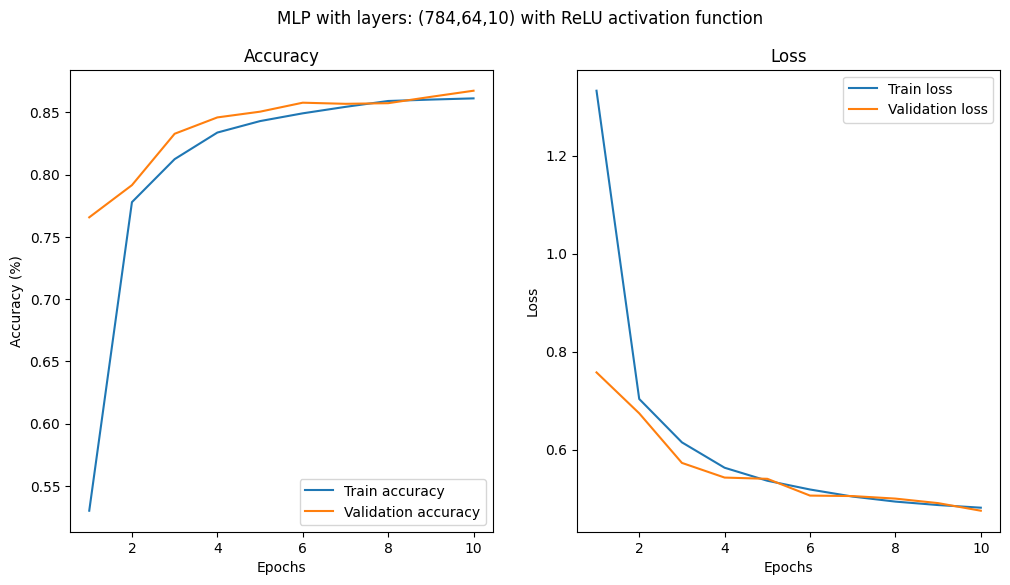

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_mlp, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_mlp, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_mlp, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_mlp, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('MLP with layers: (784,64,10) with ReLU activation function')
fig.show()

Plotting KAN

/tmp/ipykernel_7982/1405184315.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


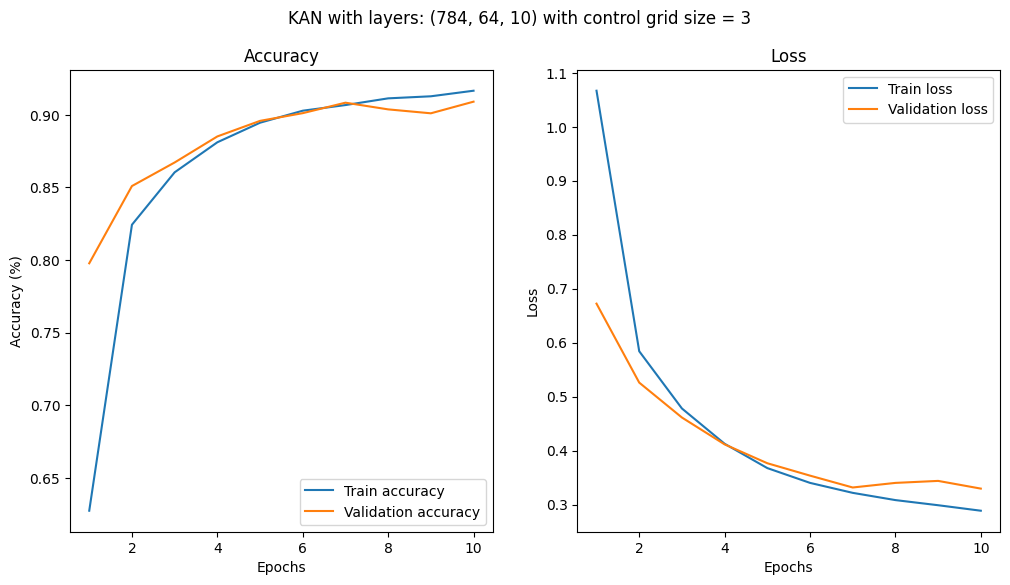

In [10]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), train_accs_kan, label='Train accuracy')
ax1.plot(range(1, num_epochs+1), val_accs_kan, label='Validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_losses_kan, label='Train loss')
ax2.plot(range(1, num_epochs+1), val_losses_kan, label='Validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Loss')
ax2.legend()

fig.suptitle('KAN with layers: (784, 64, 10) with control grid size = 3')
fig.show()